In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import re
import nltk
from wordcloud import WordCloud


In [2]:
df_tweet = pd.read_csv("Tweet.csv")

In [3]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   tweet_id     int64 
 1   writer       object
 2   post_date    int64 
 3   body         object
 4   comment_num  int64 
 5   retweet_num  int64 
 6   like_num     int64 
dtypes: int64(5), object(2)
memory usage: 198.6+ MB


In [4]:
df_tweet.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [5]:
df_company_tweet = pd.read_csv("Company_Tweet.csv")

In [6]:
df_company_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
dtypes: int64(1), object(1)
memory usage: 66.2+ MB


In [7]:
df_company_tweet.head()

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL


In [8]:
tweets = pd.merge(df_company_tweet,df_tweet,on= "tweet_id", how = "inner")

In [9]:
tweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


In [10]:
def datasetInfo(dataset):
    print(f" Dataset Information and type \n {dataset.info()}")
    print("--------------------------------------------------------\n\n Data Types: ")
    print(dataset.dtypes)
    print("--------------------------------------------------------\n\n Rows and Columns: ")
    print(dataset.shape)
    print("--------------------------------------------------------\n\n Column Names: ")
    print(dataset.columns)
    print("--------------------------------------------------------\n\n Null Values: ")
    print(dataset.apply(lambda x: sum(x.isnull()) / len(dataset)))
    print("--------------------------------------------------------\n\n Unique Values: ")
    print(dataset.nunique())
    print("--------------------------------------------------------\n\n Describe: ")
    print(dataset.describe())

In [11]:
datasetInfo(tweets)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
 2   writer         object
 3   post_date      int64 
 4   body           object
 5   comment_num    int64 
 6   retweet_num    int64 
 7   like_num       int64 
dtypes: int64(5), object(3)
memory usage: 297.8+ MB
 Dataset Information and type 
 None
--------------------------------------------------------

 Data Types: 
tweet_id          int64
ticker_symbol    object
writer           object
post_date         int64
body             object
comment_num       int64
retweet_num       int64
like_num          int64
dtype: object
--------------------------------------------------------

 Rows and Columns: 
(4336445, 8)
--------------------------------------------------------

 Column Names: 
Index(['tweet_id', 'ticker_symbol', 'writer', 'post_date', 'body',
       'comment_num

After Merging Remove the dataframes that do not have ticker_symbols

In [12]:
tweets.dropna(inplace = True)

Convert our post_date time in seconds to date_time

In [13]:
tweets['post_date'] = pd.to_datetime(tweets["post_date"],utc = False , unit = 's',).dt.normalize()
tweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
0,550803612197457920,AAPL,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
1,550803612197457920,AMZN,SentiQuant,2015-01-01,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
2,550803610825928706,AAPL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
3,550803610825928706,GOOGL,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
4,550803610825928706,AMZN,SentiQuant,2015-01-01,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1


We need our a training set and a testing set for the prediction of Neutral or Opinionated Tweets

In [14]:
tweets.sort_values(by = "comment_num" , ascending  = False, inplace = True)
tweets


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0
...,...,...,...,...,...,...,...,...
1488123,1060565704389378055,AAPL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1
1488124,1060565704389378055,GOOGL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1
1488125,1060566279818366977,AAPL,jordanladz,2018-11-08,Get audible updates with this new application....,0,0,0
1488126,1060566346763849735,AAPL,CompoundFreedom,2018-11-08,Apple Opens First Store in Thailand Saturday h...,0,0,0


## First Find the sum of all the activities in the tweet post

In [15]:
tweets["tweet_activity"] = tweets["comment_num"] + tweets["like_num"] + tweets["retweet_num"]
tweets

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0,442
...,...,...,...,...,...,...,...,...,...
1488123,1060565704389378055,AAPL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1,1
1488124,1060565704389378055,GOOGL,ScottSegen,2018-11-08,Mark Zuckerberg turns down UK parliament reque...,0,0,1,1
1488125,1060566279818366977,AAPL,jordanladz,2018-11-08,Get audible updates with this new application....,0,0,0,0
1488126,1060566346763849735,AAPL,CompoundFreedom,2018-11-08,Apple Opens First Store in Thailand Saturday h...,0,0,0,0


## Filter Tweets that are >= 50 activities

In [16]:
filterTweets = tweets.loc[tweets["tweet_activity"] > 50]

In [17]:
filterTweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,"I’d just like to point out that right now, rig...",631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,"If a Tesla saves you $200 a month on gas, you ...",567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,~Tesla feature request thread~Feel free to rep...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,"""I sell books."" versus ""I sell whatever the fu...",496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,“I think it's basically financially insane to ...,442,0,0,442


In [18]:
datasetInfo(filterTweets)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41625 entries, 3786974 to 1488017
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        41625 non-null  int64         
 1   ticker_symbol   41625 non-null  object        
 2   writer          41625 non-null  object        
 3   post_date       41625 non-null  datetime64[ns]
 4   body            41625 non-null  object        
 5   comment_num     41625 non-null  int64         
 6   retweet_num     41625 non-null  int64         
 7   like_num        41625 non-null  int64         
 8   tweet_activity  41625 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 3.2+ MB
 Dataset Information and type 
 None
--------------------------------------------------------

 Data Types: 
tweet_id                   int64
ticker_symbol             object
writer                    object
post_date         datetime64[ns]
bo

### Data Cleaning and Tokenization of text body

In [19]:
from nltk.corpus import stopwords

def removeStopWords(df):
    finalList = []
    stop_words = set(stopwords.words('english'))
    for word in df:
        if word not in stop_words:
            finalList.append(word)
    df = finalList
    return df

In [20]:
from nltk.stem.porter import *

def stem_text(text):
    
    stemmer = PorterStemmer()
   
    return [stemmer.stem(word) for word in text]

In [21]:
def lemmatised_text(text):
    lemmatiser = nltk.stem.WordNetLemmatizer()
    return [lemmatiser.lemmatize(word) for word in text]

In [22]:
import pandas as pd
import re



def clean_dataframe_text(df, column,lemma):
    
    
    # Remove any non-alphanumeric characters and replace them with spaces
    df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
    
    # Replace 's with 'is' or 'has'
    df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'s", lambda m: 'is' if m.group(1) in ['he', 'she', 'it'] else 'has', x))
    
    # Remove any non-alphanumeric characters and replace them with spaces
    df[column] = df[column].apply(lambda x: re.sub(r'[^\w\s]', '', x))
    
    # Replace any consecutive whitespace characters with a single space
    df[column] = df[column].apply(lambda x: re.sub(r'\s+', ' ', x))
    
    df[column] = df[column].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    
    # Replace any consecutive whitespace characters with a single space
    df[column] = df[column].apply(lambda x: re.sub(r'\s+', ' ', x))
    
    df[column] = df[column].apply(lambda x: re.sub(r'\d+', '', x))
    
    # Convert the string in lower
    df[column] = df[column].str.lower()
    
    # Tokenised the words
    df[column]  = df[column].apply(lambda x : nltk.word_tokenize(x))

    # Remove stopwords from the NLTK stopword list
    df[column] = df[column].apply(lambda x : removeStopWords(x))
    
    if lemma:
    # Porter Stemmer
        df[column] = df[column].apply(lambda x : lemmatised_text(x))
    else:
        df[column] = df[column].apply(lambda x : stem_text(x))
    #concatenate the tokenised list into string
    df[column] = df[column].apply(lambda x: ' '.join(x))
    
      
    return df

In [23]:
#False: Stemming True: Lemmatization
clean_dataframe_text(filterTweets,"body",False)

C:\Users\eric2\AppData\Local\Temp\ipykernel_30044\1040190935.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'d", lambda m: 'would' if m.group(1) in ['he', 'she', 'it', 'that'] else 'had', x))
C:\Users\eric2\AppData\Local\Temp\ipykernel_30044\1040190935.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: re.sub(r"(\w+)'s", lambda m: 'is' if m.group(1) in ['he', 'she', 'it'] else 'has', x))
C:\Users\eric2\AppD

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442
...,...,...,...,...,...,...,...,...,...
1498488,1063566557677146112,AAPL,financialbuzz,2018-11-16,watch us report live floor nyse week weekli wr...,0,126,80,206
1498489,1063566683720175616,AAPL,financialbuzz,2018-11-16,watch us report live floor nyse week weekli wr...,0,86,62,148
1498490,1063566957956349952,AAPL,financialbuzz,2018-11-16,watch us report live floor nyse week weekli wr...,0,117,41,158
1482004,1058502476406632448,AAPL,financialbuzz,2018-11-02,watch us report live floor nyse week weekli wr...,0,155,0,155


In [24]:
filterTweets

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442
...,...,...,...,...,...,...,...,...,...
1498488,1063566557677146112,AAPL,financialbuzz,2018-11-16,watch us report live floor nyse week weekli wr...,0,126,80,206
1498489,1063566683720175616,AAPL,financialbuzz,2018-11-16,watch us report live floor nyse week weekli wr...,0,86,62,148
1498490,1063566957956349952,AAPL,financialbuzz,2018-11-16,watch us report live floor nyse week weekli wr...,0,117,41,158
1482004,1058502476406632448,AAPL,financialbuzz,2018-11-02,watch us report live floor nyse week weekli wr...,0,155,0,155


In [25]:
# filterTweets["body"].apply(lambda x : clean_tweet(x))
# filterTweets["body"].apply(lambda x : x.translate(str.maketrans('', '' , string.punctuation)))
# filterTweets["body"]
# filterTweets["body"].apply(lambda x : nltk.word_tokenize(x))

In [26]:
filterTweets["body"].head()

3786974    id like point right right moment elonmusk go f...
4112626    tesla save month ga ten year take save put bal...
4306536    tesla featur request threadfeel free repli ill...
2823018           sell book versu sell whatev fuck want amzn
4182686    think basic financi insan buy anyth except ele...
Name: body, dtype: object

### Tweet EDA

In [27]:
filterTweets["writer"].describe()


count           41625
unique           2797
top       TESLAcharts
freq             2212
Name: writer, dtype: object

### Writer Data Exploration

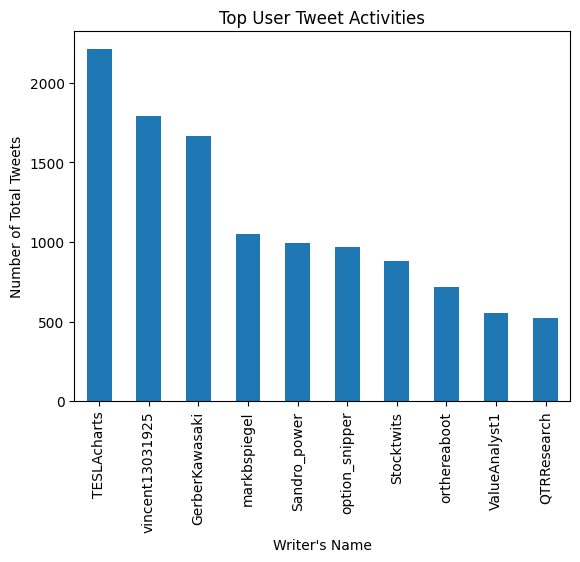

In [69]:

counts = filterTweets["writer"].value_counts(ascending= False)
countsFilter = counts[:10]
countsFilter.plot(kind="bar")

plt.title("Top User Tweet Activities")
plt.ylabel("Number of Total Tweets")
plt.xlabel("Writer's Name")
plt.show()

Graph above shows the top writers that are active and have >100 posts

<AxesSubplot: ylabel='ticker_symbol'>

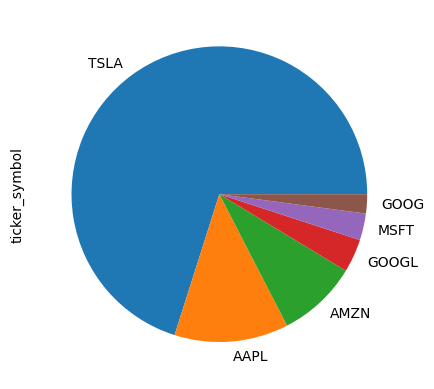

In [29]:

counts = filterTweets["ticker_symbol"].value_counts()
counts.plot(kind="pie")

Notice that there are more TSLA tweets in the dataset.

### Active Tweets dates

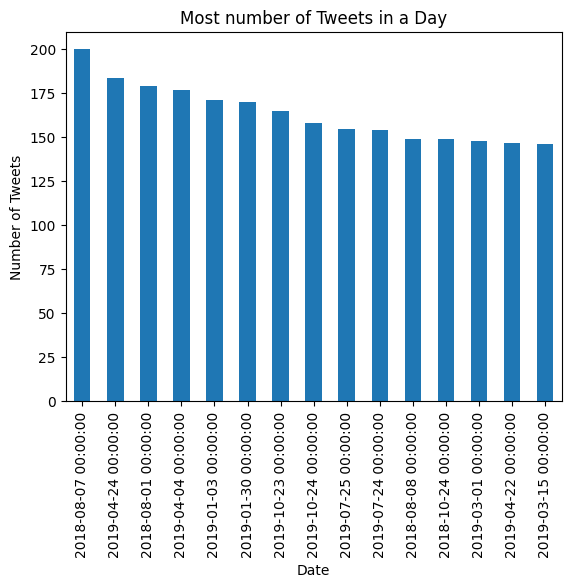

In [71]:
count = filterTweets["post_date"].value_counts(ascending = False)
count
filterCounts = count[:15]
filterCounts.plot(kind = "bar")
plt.title("Most number of Tweets in a Day")
plt.ylabel("Number of Tweets")
plt.xlabel("Date")
plt.show()

Above bar graphs shows the highest tweets in the respective days

### Word Cloud of Tweets

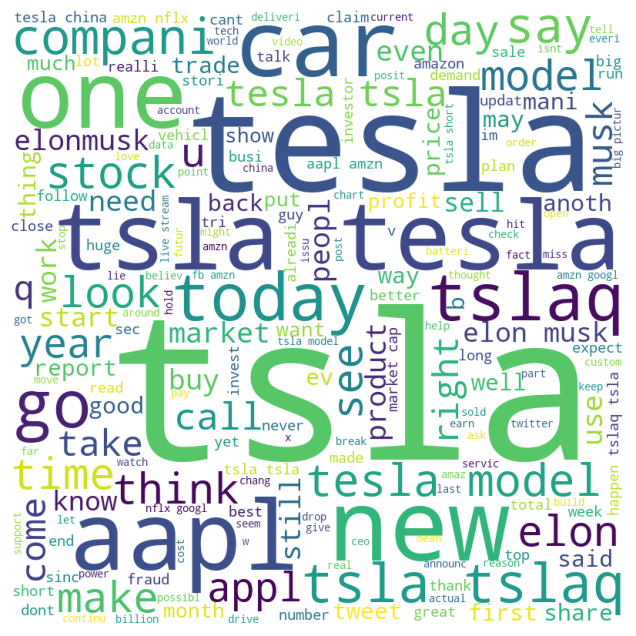

In [31]:
text = " ".join(filterTweets["body"])
wordcloud = WordCloud(width = 800, height = 800, background_color='white', max_words = 200)
wordcloud.generate(text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

From the word cloud we can tell that TSLA/TESLA and AAPL are common tweets in Twitter

# Polarity Detection

### Import Sentiment Analyser from NLTK

In [32]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [33]:
analyser = SentimentIntensityAnalyzer()

In [34]:
def getSentiment(body):
    analyser = SentimentIntensityAnalyzer()
    
    assert body is not None
    sentimentAnalysis = analyser.polarity_scores(body)
    score = sentimentAnalysis['compound']
    
    if (score >= 0.05):
        return "Positive"
    elif (score < 0.05 and score > -0.05):
        return "Neutral"
    elif (score <= -0.05):
        return "Negative"
    
    print(score)
    

In [35]:
filterTweets['sentiment'] = filterTweets['body'].apply(lambda x : getSentiment(x))

filterTweets


C:\Users\eric2\AppData\Local\Temp\ipykernel_30044\1991431580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweets['sentiment'] = filterTweets['body'].apply(lambda x : getSentiment(x))


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,Positive
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,Positive
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,Positive
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,Negative
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,Positive
...,...,...,...,...,...,...,...,...,...,...
1498488,1063566557677146112,AAPL,financialbuzz,2018-11-16,watch us report live floor nyse week weekli wr...,0,126,80,206,Neutral
1498489,1063566683720175616,AAPL,financialbuzz,2018-11-16,watch us report live floor nyse week weekli wr...,0,86,62,148,Neutral
1498490,1063566957956349952,AAPL,financialbuzz,2018-11-16,watch us report live floor nyse week weekli wr...,0,117,41,158,Neutral
1482004,1058502476406632448,AAPL,financialbuzz,2018-11-02,watch us report live floor nyse week weekli wr...,0,155,0,155,Positive


### Testing out TextBlob Sentimental Analysis

In [36]:
from textblob import TextBlob

In [37]:
# Function to use TextBlob (Sentimental Analysis [Objectivity & Polarity])

def add_sentiment_scores_blob(df, text_column, polarity_threshold = 0.0 , subjectivity_threshold = 0.5):
    # Compute polarity and subjectivity scores for each row in the specified text column
    scores = df[text_column].apply(lambda x: TextBlob(x).sentiment)
    
    # Add two new columns to the DataFrame for the polarity and subjectivity scores
    df['blob_polarity'] = scores.apply(lambda x: x.polarity)
    df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
    
    # Convert polarity score to class (positive, neutral, or negative) based on the specified threshold
    df['blob_polarity'] = df['blob_polarity'].apply(lambda x: 'Positive' if x > polarity_threshold else 'Negative' if x < -polarity_threshold else 'Neutral')
    
    # Convert subjectivity score to class (subjective or objective) based on the specified threshold
    df['blob_subjectivity'] = df['blob_subjectivity'].apply(lambda x: 'Subjective' if x > subjectivity_threshold else 'Objective')
    
    return df
    
    

In [38]:
add_sentiment_scores_blob(filterTweets,"body", 0.0, 0.5)

C:\Users\eric2\AppData\Local\Temp\ipykernel_30044\2951990553.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_polarity'] = scores.apply(lambda x: x.polarity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_30044\2951990553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['blob_subjectivity'] = scores.apply(lambda x: x.subjectivity)
C:\Users\eric2\AppData\Local\Temp\ipykernel_30044\2951990553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,Positive,Positive,Subjective
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,Positive,Positive,Objective
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,Positive,Negative,Subjective
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,Negative,Negative,Subjective
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,Positive,Negative,Objective
...,...,...,...,...,...,...,...,...,...,...,...,...
1498488,1063566557677146112,AAPL,financialbuzz,2018-11-16,watch us report live floor nyse week weekli wr...,0,126,80,206,Neutral,Positive,Objective
1498489,1063566683720175616,AAPL,financialbuzz,2018-11-16,watch us report live floor nyse week weekli wr...,0,86,62,148,Neutral,Positive,Objective
1498490,1063566957956349952,AAPL,financialbuzz,2018-11-16,watch us report live floor nyse week weekli wr...,0,117,41,158,Neutral,Positive,Objective
1482004,1058502476406632448,AAPL,financialbuzz,2018-11-02,watch us report live floor nyse week weekli wr...,0,155,0,155,Positive,Positive,Objective


### Convert Positive, Negative and Neutral to numeral labels

In [39]:
sentiment_map = {"Positive": 1, "Negative": 0, "Neutral": 2}

In [40]:
filterTweets["sentiment"].replace(sentiment_map, inplace = True)
filterTweets["blob_polarity"].replace(sentiment_map, inplace = True)

C:\Users\eric2\AppData\Local\Temp\ipykernel_30044\3903232632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweets["sentiment"].replace(sentiment_map, inplace = True)
C:\Users\eric2\AppData\Local\Temp\ipykernel_30044\3903232632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filterTweets["blob_polarity"].replace(sentiment_map, inplace = True)


### Splitting up data for Prediction using ensemble machine learning models For NLTK.Sentiment Analysis

In [41]:
X = filterTweets["body"] #["ticker_symbol","writer" , "body"]
y = filterTweets["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

In [42]:
X_train.info()
X_train.head()

<class 'pandas.core.series.Series'>
Int64Index: 31218 entries, 4261783 to 1436407
Series name: body
Non-Null Count  Dtype 
--------------  ----- 
31218 non-null  object
dtypes: object(1)
memory usage: 487.8+ KB


4261783    patheticthat tesla attempt deliv car condition...
4111496    sourc tsla pare lose amid report tesla unoffic...
1573703    big earn week amzn aapl amd fb msft baba tsla ...
3954714    thread chart puzzl ih markit registr data tsla...
1581966    watch us report live floor nyse week weekli wr...
Name: body, dtype: object

In [43]:
X_test.info()
X_test.head()

<class 'pandas.core.series.Series'>
Int64Index: 10407 entries, 4076760 to 3742364
Series name: body
Non-Null Count  Dtype 
--------------  ----- 
10407 non-null  object
dtypes: object(1)
memory usage: 162.6+ KB


4076760    great writeup potenti recoveri bondhold bankru...
4226495    tsla competit kill dealer ipac inventori pile ...
4321661    rais hand agre let tsla beta test danger softw...
2494776    good interview brilliant p_ferragu like intc a...
4056663                              realli classi move tsla
Name: body, dtype: object

In [44]:
y_train.info()
y_train.head()

<class 'pandas.core.series.Series'>
Int64Index: 31218 entries, 4261783 to 1436407
Series name: sentiment
Non-Null Count  Dtype
--------------  -----
31218 non-null  int64
dtypes: int64(1)
memory usage: 487.8 KB


4261783    1
4111496    0
1573703    2
3954714    1
1581966    2
Name: sentiment, dtype: int64

In [45]:
y_test.info()
y_test.head()


<class 'pandas.core.series.Series'>
Int64Index: 10407 entries, 4076760 to 3742364
Series name: sentiment
Non-Null Count  Dtype
--------------  -----
10407 non-null  int64
dtypes: int64(1)
memory usage: 162.6 KB


4076760    1
4226495    0
4321661    0
2494776    1
4056663    2
Name: sentiment, dtype: int64

In [46]:
filterTweets["sentiment"].value_counts()

1    16655
2    14886
0    10084
Name: sentiment, dtype: int64


### Separating Neutral Sentiments and Opinionated Sentiments

In [47]:
opinionatedTweets = filterTweets.loc[filterTweets["sentiment"]!= 2]
opinionatedTweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment,blob_polarity,blob_subjectivity
3786974,1014983757252780033,TSLA,lopezlinette,2018-07-05,id like point right right moment elonmusk go f...,631,369,0,1000,1,1,Subjective
4112626,1118989675257978880,TSLA,GerberKawasaki,2019-04-18,tesla save month ga ten year take save put bal...,567,0,0,567,1,1,Objective
4306536,1199424478536753155,TSLA,AlexSibila,2019-11-26,tesla featur request threadfeel free repli ill...,563,48,662,1273,1,0,Subjective
2823018,885933344487342082,AMZN,internet_dust,2017-07-14,sell book versu sell whatev fuck want amzn,496,0,0,496,0,0,Subjective
4182686,1138975188127834112,TSLA,TeslaNY,2019-06-13,think basic financi insan buy anyth except ele...,442,0,0,442,1,0,Objective


In [48]:
neutralTweets = filterTweets.loc[filterTweets["sentiment"] == 2]
neutralTweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,tweet_activity,sentiment,blob_polarity,blob_subjectivity
4002464,1082182633948295168,TSLA,vincent13031925,2019-01-07,tesla ceo elonmusk shanghai mayor ying yong te...,318,0,0,318,2,2,Objective
4142690,1126183436144795649,TSLA,TeslaNY,2019-05-08,test product car ever crack second mph tesla s...,280,0,0,280,2,2,Objective
4301361,1197894016358060032,TSLA,carlquintanilla,2019-11-22,caption pleasetsla cybertruckvia teflongeek,276,27,201,504,2,2,Objective
1336141,993863874406420481,AAPL,philstockworld,2018-05-08,trillion dollar tuesday appl close histor valu...,213,489,387,1089,2,2,Objective
1568450,1087700913752600576,AAPL,jimcramer,2019-01-22,hatr aapl reject idea help custom healthcar wa...,204,66,757,1027,2,2,Objective


## Machine Learnining Model for NLTK Sentimental Analysis

In [49]:
def metric_report(y_test,y_pred):
    accuracy = accuracy_score(y_test,y_pred)
    fmeasure = f1_score(y_test,y_pred, average = "weighted")
    recall = recall_score(y_test, y_pred, average = "weighted")
    precision = precision_score(y_test, y_pred, average = "weighted")
    print(f"The accuracy of the Model is {accuracy}")
    print(f"The F-Score of the Model is {fmeasure}")
    print(f"The Recall of the Model is {recall}")
    print(f"The precision of the Model is {precision}")

### Create a Naive_bayes Model

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [51]:
vectoriser = CountVectorizer()

X_train_vec = vectoriser.fit_transform(X_train)
X_test_vec = vectoriser.transform(X_test)

# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

# Make predictions on test data
y_pred = clf.predict(X_test_vec)

# Evaluate the model using accuracy score
metric_report(y_test,y_pred)

The accuracy of the Model is 0.7020274815028347
The F-Score of the Model is 0.6966401786562404
The Recall of the Model is 0.7020274815028347
The precision of the Model is 0.735952627354848


### Create a Decision Tree Classifier

In [52]:
clf = DecisionTreeClassifier()
clf.fit(X_train_vec,y_train)

y_pred = clf.predict(X_test_vec)

metric_report(y_test,y_pred)


The accuracy of the Model is 0.8771019506101663
The F-Score of the Model is 0.8758093822973598
The Recall of the Model is 0.8771019506101663
The precision of the Model is 0.875575118304495


### Create a Ensemble Learning Classifier


In [53]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [54]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

# Train the ensemble classifier
ensemble.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_vec)

# Evaluate the accuracy of the model
metric_report(y_test,y_pred)

The accuracy of the Model is 0.8857499759777073
The F-Score of the Model is 0.8830741521748249
The Recall of the Model is 0.8857499759777073
The precision of the Model is 0.8860980974580401


### Support Vector Machine Models


In [55]:
from sklearn import svm
clf = svm.SVC(kernel = "rbf",random_state = 1)
clf.fit(X_train_vec,y_train)

SVC(random_state=1)

In [56]:
svm_pred = clf.predict(X_test_vec)


In [57]:
metric_report(y_test,svm_pred)

The accuracy of the Model is 0.8628807533390986
The F-Score of the Model is 0.8601224473413907
The Recall of the Model is 0.8628807533390986
The precision of the Model is 0.8641845297911553


### Neural Network

In [58]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
clf.fit(X_train_vec,y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(128,), max_iter=1000,
              random_state=1, solver='lbfgs')

In [59]:
nn_pred = clf.predict(X_test_vec)
print(nn_pred)

[1 0 1 ... 1 0 0]


In [60]:
metric_report(y_test,nn_pred)

The accuracy of the Model is 0.8998750840780244
The F-Score of the Model is 0.8994911421235593
The Recall of the Model is 0.8998750840780244
The precision of the Model is 0.8992936583892842


## Doing up Machine Learning Models for TextBlob Analysis

In [61]:
X = filterTweets["body"] 
y = filterTweets["blob_polarity"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

### Naive Bayes ML Model

In [62]:
vectoriser = CountVectorizer()

X_train_vec = vectoriser.fit_transform(X_train)
X_test_vec = vectoriser.transform(X_test)

# Train the model using Naive Bayes algorithm
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

# Make predictions on test data
y_pred = clf.predict(X_test_vec)

# Evaluate the model using accuracy score
metric_report(y_test,y_pred)

The accuracy of the Model is 0.756413952147593
The F-Score of the Model is 0.7548979988212197
The Recall of the Model is 0.756413952147593
The precision of the Model is 0.7933688751701902


### Create Decision Tree ML Model

In [63]:
clf = DecisionTreeClassifier()
clf.fit(X_train_vec,y_train)

y_pred = clf.predict(X_test_vec)

metric_report(y_test,y_pred)


The accuracy of the Model is 0.9502258095512636
The F-Score of the Model is 0.9499329466030161
The Recall of the Model is 0.9502258095512636
The precision of the Model is 0.9499353364772081


### Random Forest ML Model

In [64]:
clf = RandomForestClassifier()
clf.fit(X_train_vec,y_train)

y_pred = clf.predict(X_test_vec)

metric_report(y_test,y_pred)


The accuracy of the Model is 0.9301431728644182
The F-Score of the Model is 0.927194503938412
The Recall of the Model is 0.9301431728644182
The precision of the Model is 0.9310007916680684


### Ensemble Learning

In [65]:
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = SVC()

# Create the ensemble classifier
ensemble = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')

# Train the ensemble classifier
ensemble.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = ensemble.predict(X_test_vec)

# Evaluate the accuracy of the model
metric_report(y_test,y_pred)

The accuracy of the Model is 0.9399442682809648
The F-Score of the Model is 0.93797766338149
The Recall of the Model is 0.9399442682809648
The precision of the Model is 0.9400922835997577


### Support Vector Machine Model

In [66]:
svm_pred = clf.predict(X_test_vec)

In [67]:

metric_report(y_test,svm_pred)


The accuracy of the Model is 0.9301431728644182
The F-Score of the Model is 0.927194503938412
The Recall of the Model is 0.9301431728644182
The precision of the Model is 0.9310007916680684


### Neural Network Model



In [68]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver = "lbfgs", alpha = 1e-5, 
                    hidden_layer_sizes =(128,), random_state=1, max_iter = 1000)
clf.fit(X_train_vec,y_train)

nn_pred = clf.predict(X_test_vec)
metric_report(y_test,nn_pred)

The accuracy of the Model is 0.9528202171615259
The F-Score of the Model is 0.9525420622398062
The Recall of the Model is 0.9528202171615259
The precision of the Model is 0.9524614494679544
